In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import sys

sys.path.insert(0, "../")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa

from scipy import signal
from scipy.ndimage.filters import gaussian_filter1d

from tqdm import tqdm_notebook

import config
from audio import audio_to_melspectrogram, show_melspectrogram
from utils import load_labels, show_spectrograms

<IPython.core.display.Javascript object>

## Load data

In [3]:
# read data
X_train = np.load("../data/DOCC10_train/DOCC10_Xtrain.npy")
X_test = np.load("../data/DOCC10_test/DOCC10_Xtest.npy")
Y_train_df = pd.read_csv("../data/DOCC10_train/DOCC10_Ytrain.csv", index_col=0)

# Shift indexes
Y_train_df.index = Y_train_df.index - 20960

all_classes = list(set(Y_train_df.TARGET.values))

print("X train", X_train.shape, "Y_train", Y_train_df.shape, "X_test", X_test.shape)

X train (113120, 8192) Y_train (113120, 1) X_test (20960, 8192)


<IPython.core.display.Javascript object>

## Segment clicks 

In [4]:
def get_center(x_r):
    # Parameters
    cutoff = 10000
    win_size = 50
    gaussian_std = 5
    fs = 200000
    nyq = fs // 2
    order = 2
    normal_cutoff = cutoff / nyq

    # Butterworth highpass filter
    b, a = signal.butter(order, normal_cutoff, btype="high", analog=False)
    x_h = signal.filtfilt(b, a, x_r)

    # Wiener filter
    x_w = signal.wiener(x_h, mysize=win_size)

    # Gaussian filter
    x_g = gaussian_filter1d(np.abs(x_w), gaussian_std)

    # Argmax of the resulting signal
    center = x_g.argmax()

    return center

<IPython.core.display.Javascript object>

In [5]:
def show_centers(n_plots, classes):
    fig, axes = plt.subplots(
        n_plots, len(classes), figsize=(2 * len(classes), 2 * n_plots)
    )
    for j in range(len(classes)):
        X_sub = X_train[(Y_train_df == classes[j]).values.flatten()]
        axes[0, j].set_title(classes[j])
        for i in range(n_plots):
            idx = np.random.randint(len(X_sub))
            center = get_center(X_sub[idx])
            axes[i, j].plot(X_sub[idx])
            axes[i, j].axvline(x=center, color="red")
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)
    plt.show()

<IPython.core.display.Javascript object>

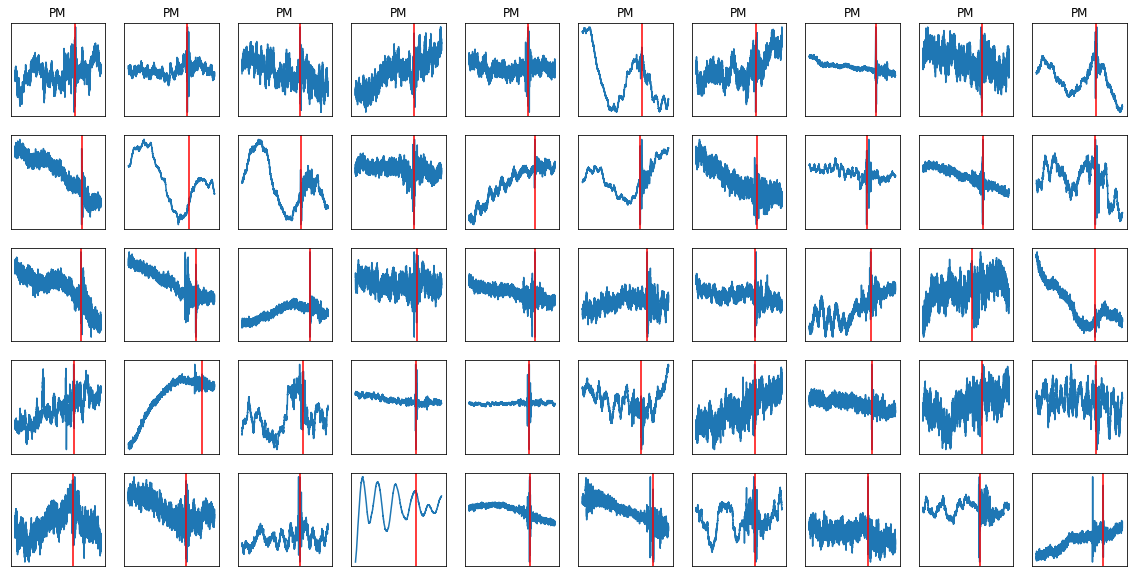

<IPython.core.display.Javascript object>

In [6]:
show_centers(5, ["PM"] * 10)

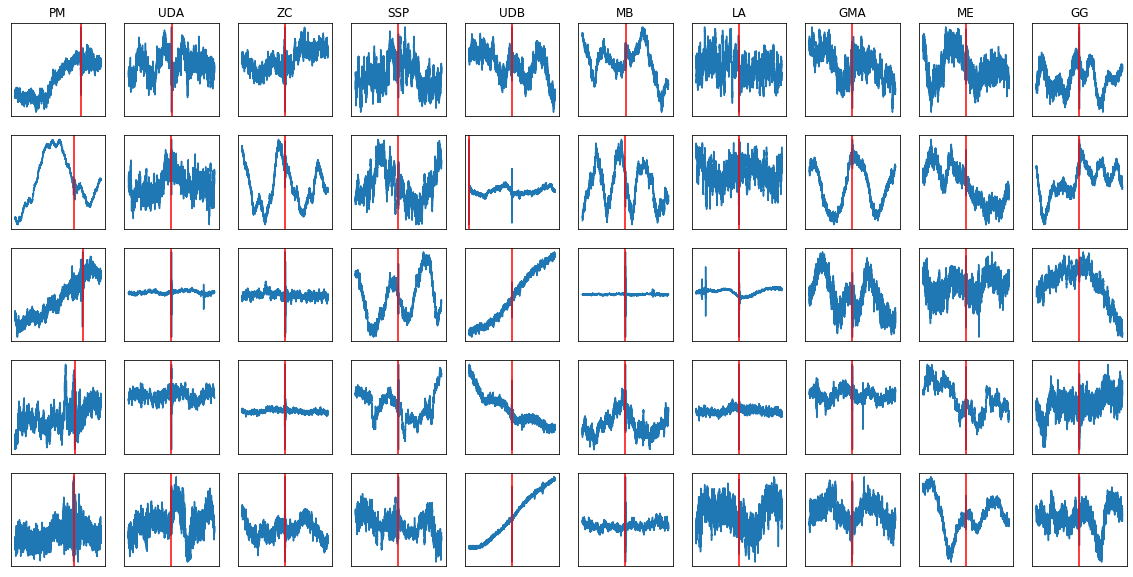

<IPython.core.display.Javascript object>

In [7]:
show_centers(5, all_classes)

In [8]:
def segment_clicks(x, cls=None, width=2 ** 8):
    T = len(x)
    assert width < T
    if cls == "PM":
        center = get_center(x)
    else:
        center = 2 ** 12
    if center - width // 2 < 0:
        min_t = 0
        max_t = width
    elif center + width // 2 >= T:
        min_t = -width
        max_t = T
    else:
        min_t = center - width // 2
        max_t = center + width // 2
    x_sub = x[min_t:max_t]
    assert len(x_sub) == width
    return x_sub

<IPython.core.display.Javascript object>

## Spectral features

### Feature: centered power spectrum bins

In [9]:
def get_power_spectrum(x, n_fft=64):
    n_fft = 64
    cutoff = 10000
    f_sampling = 200000
    window = signal.get_window(("gaussian", 30), n_fft)

    f, pspec = signal.welch(x, f_sampling, window, n_fft, scaling="spectrum")

    # Keep only freq > 10kHz
    pspec = pspec[f > cutoff]
    f = f[f > cutoff]
    return f, pspec

<IPython.core.display.Javascript object>

In [10]:
def show_temporal(x):
    plt.figure(figsize=(10, 5))
    plt.title("Signal")
    plt.plot(x)
    plt.yticks([])
    plt.show()


def show_power_spectrum(f, ps):
    plt.figure(figsize=(10, 5))
    plt.title("Power spectrum")
    N = len(f)
    ind = np.arange(N)
    delta = f[1] - f[0]
    xlabels = (f - delta / 2).astype(int)
    plt.bar(x=ind, height=ps)
    plt.xticks(ind, xlabels, rotation=45)
    plt.yticks([])
    plt.show()

<IPython.core.display.Javascript object>

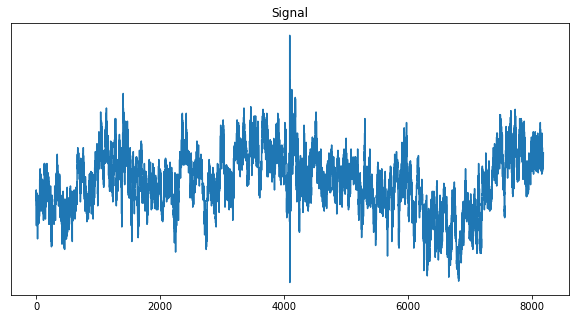

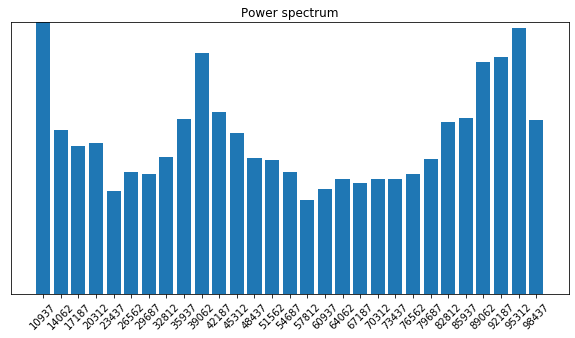

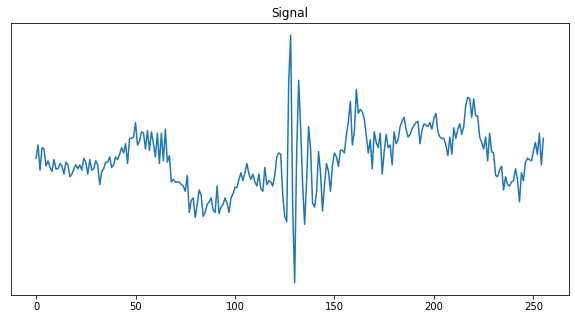

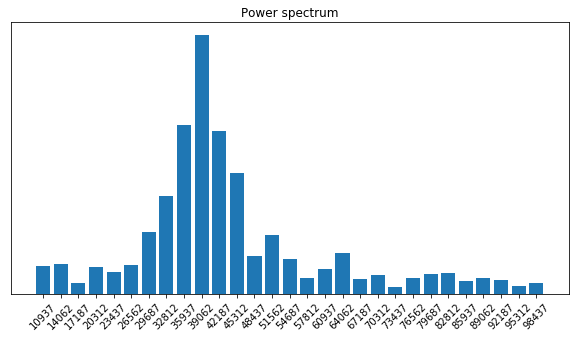

<IPython.core.display.Javascript object>

In [11]:
# Test
x = X_train[0]
f, ps = get_power_spectrum(x, n_fft=64)
x_c = segment_clicks(x, cls=None, width=2 ** 8)
f_c, ps_c = get_power_spectrum(x_c, n_fft=64)

show_temporal(x)
show_power_spectrum(f, ps)
show_temporal(x_c)
show_power_spectrum(f_c, ps_c)

In [12]:
def show_power_spectrum_per_class(n_plots, classes):
    fig, axes = plt.subplots(
        n_plots, len(classes), figsize=(2 * len(classes), 2 * n_plots)
    )
    for j, cls in enumerate(classes):
        X_sub = X_train[(Y_train_df == classes[j]).values.flatten()]
        axes[0, j].set_title(classes[j])
        for i in range(n_plots):
            idx = np.random.randint(len(X_sub))
            x = X_sub[idx]
            x_c = segment_clicks(x, cls, width=2 ** 8)
            f_c, ps_c = get_power_spectrum(x_c, n_fft=64)
            # axes[i, j].plot(f_c, ps_c)
            axes[i, j].bar(x=1.5 * np.arange(len(f_c)), height=ps_c)
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)
    plt.show()

<IPython.core.display.Javascript object>

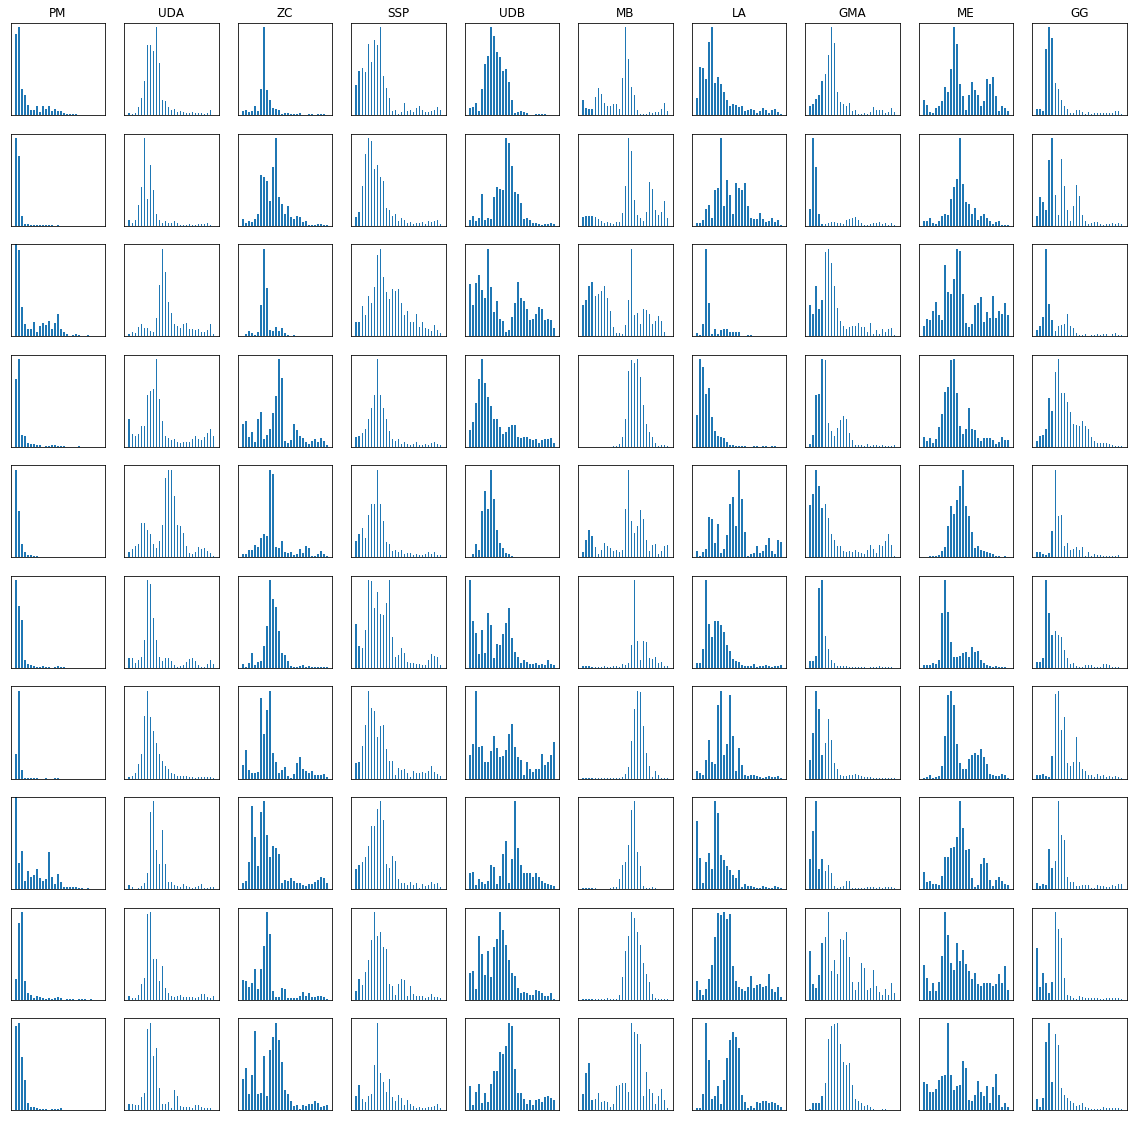

<IPython.core.display.Javascript object>

In [13]:
show_power_spectrum_per_class(10, all_classes)

### Feature: spectral width

## Training a linear model

In [14]:
Y = Y_train_df.TARGET.tolist()

<IPython.core.display.Javascript object>

In [15]:
def build_ps_features():
    n_samples = X_train.shape[0]
    n_feats = 29
    X = np.zeros((n_samples, n_feats), dtype=np.float32)
    for i in tqdm_notebook(range(n_samples)):
        x = segment_clicks(X_train[i], cls=Y[i], width=2 ** 8)
        _, ps = get_power_spectrum(x, n_fft=64)
        X[i] = ps
    return X

<IPython.core.display.Javascript object>

In [16]:
X = build_ps_features()

<IPython.core.display.Javascript object>

In [21]:
# !pip install --upgrade sklearn # requires scikit learn 0.22
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

<IPython.core.display.Javascript object>

In [22]:
# Stratified split
X_spec_train, X_spec_val, Y_train, Y_val = train_test_split(
    X, Y, stratify=Y, test_size=0.15
)
print(f"Train size: {len(X_spec_train)}, val size: {len(X_spec_val)}")

Train size: 96152, val size: 16968


<IPython.core.display.Javascript object>

In [23]:
# Scaling the training data
scaler = StandardScaler().fit(X_spec_train)

X_sc_spec_train = scaler.transform(X_spec_train)
X_sc_spec_val = scaler.transform(X_spec_val)

<IPython.core.display.Javascript object>

In [24]:
# Logistic regression
model = LogisticRegression(
    C=100,
    verbose=1,
    solver="lbfgs",
    max_iter=10000,
    multi_class="multinomial",
    random_state=0,
)
model.fit(X_sc_spec_train, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [25]:
# Val set
train_acc = model.score(X_sc_spec_train, Y_train)
val_acc = model.score(X_sc_spec_val, Y_val)

print(f"Train acc: {train_acc}")
print(f"Val acc: {val_acc}")

Train acc: 0.5163803145020385
Val acc: 0.5124351720886374


<IPython.core.display.Javascript object>

0.4207 using liblinear (learning one-vs-rest) + 1000 iters
0.468 using lbfgs+ C=5 (l2)
0.487 C=10
0.506 C=20
0.516 C=50